# problem Statement
Day by day fraud transaction is increasing. The idea was to identify fraud transaction and take quick action to cancel the transaction or to take some other action. Data are taken transactional and demographic data

# Import libraries and raw data

In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import Imputer 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics 
from sklearn.cross_validation import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix,roc_curve, auc, log_loss
from sklearn.utils import resample
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
#conda install -c anaconda py-xgboost=0.60
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier



#collecting data
#os.chdir("C:\\Users\\suman\\Desktop\\datasciencework\\fraudtransaction")
dataset = pd.read_csv('rawdata.csv')
#print(dataset.head(5))
print(dataset.sample(5))
print(dataset.shape)

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\suman\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
         step      type     amount     nameOrig  oldbalanceOrg  \
4827797   347   PAYMENT   21591.79   C8

# EDA of data

In [2]:
len(dataset.index)#6362620 rows
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

635440 7 (not isFraud) and 8213(isFraud) so we need oversampling of isFraud. 

In [3]:
dataset.info()
#as the data is imbalanced need oversampling but this is giving poor result
#dataset_majority=dataset[dataset.isFraud==0]
#dataset_minority=dataset[dataset.isFraud==1]
#df_minority_upsample=resample(dataset_minority,replace=True,n_samples=6354407,random_state=123)#random state for reproduiable
#df_upsampled=pd.concat([dataset_majority,df_minority_upsample])
#df_upsampled['isFraud'].value_counts()#now its 6354407 and 6354407
#dataset=df_upsampled


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
#do bivariant analysis of type payment and fraud(catagory vs catagory)
dataset['type'].value_counts()
pd.crosstab(index=dataset["type"],columns=dataset["isFraud"])   # 2 way table 

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [7]:
#all fraue are for type=CASH_OUT.TRANSFER
a=pd.crosstab(index=dataset["step"],columns=dataset["isFraud"])   # 2 way table   
print(a[0:10])
#in some steps fraud is more

isFraud      0   1
step              
1         2692  16
2         1006   8
3          548   4
4          555  10
5          659   6
6         1638  22
7         6825  12
8        21085  12
9        37609  19
10       35980  11


In [ ]:
#boxplot 'newbalanceDest', 'isFraud'
fig, ax = plt.subplots(figsize=(10,10))
l=['amount']
sns.boxplot(data=dataset,x='isFraud',y='amount')
plt.show()

In [12]:
#not much relation
#relation 'nameOrig', 'isFraud'
df2 = dataset.groupby(["isFraud", "nameOrig"]).size().reset_index(name='Count')
df2=df2[df2['Count'] >1]
print(df2.iloc[0:10,:])
#mostly those are not having any pattern
#relation 'nameDest', 'isFraud'



      isFraud     nameOrig  Count
851         0   C100025963      2
1412        0  C1000442951      2
3141        0  C1000947901      2
3510        0  C1001064466      2
4839        0  C1001477354      2
5183        0  C1001571964      2
5828        0  C1001770944      2
6221        0  C1001890218      2
6635        0  C1002018924      2
6662        0  C1002027777      2


In [14]:
df2 = dataset.groupby(["nameDest", "isFraud"]).size().reset_index(name='Count')
df2=df2[df2['Count'] >70]
print(df2.iloc[0:10,])
#there are some repetative same value of nameDest. some nameDest has a lot of obs but no fraud


          nameDest  isFraud  Count
4105   C1013700132        0     71
7033   C1023714065        0     97
20598  C1068824137        0     73
25598  C1085479446        0     71
29977    C11003494        0     80
50058  C1167066016        0     79
66028  C1220897602        0     74
70086  C1234776885        0     90
76141  C1255024717        0     84
78481  C1262822392        0     85


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
l=['amount']
dataset.boxplot(l,'isFraud',ax)
plt.show()

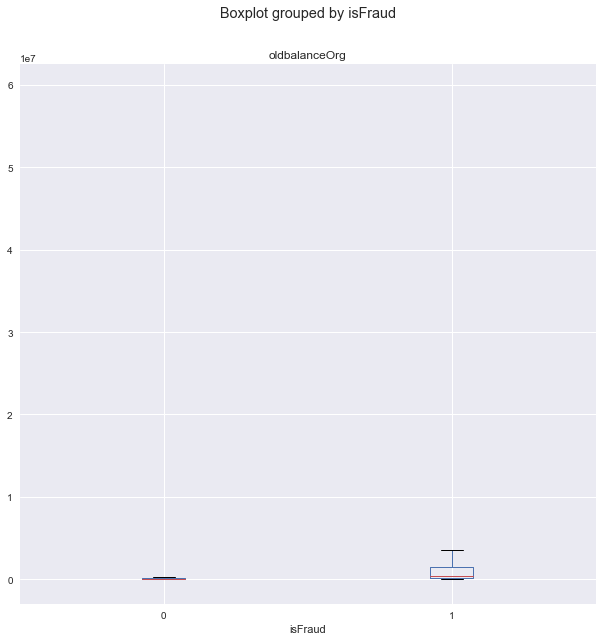

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
l=['oldbalanceOrg']
dataset.boxplot(l,'isFraud',ax)
plt.show()

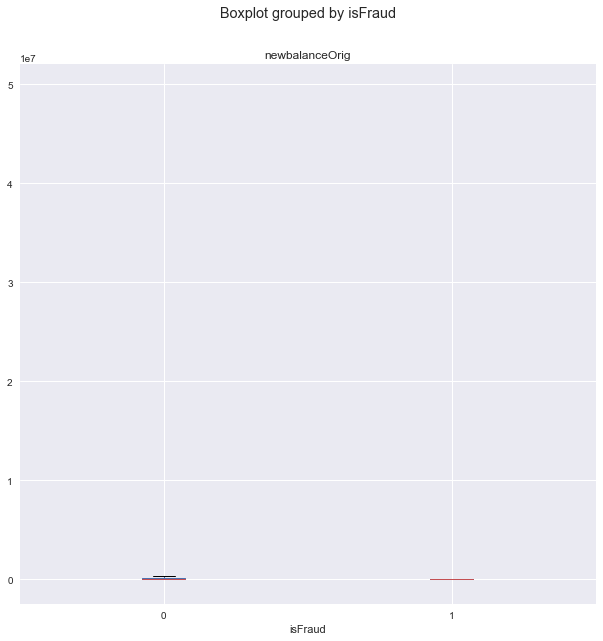

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
l=['newbalanceOrig']
dataset.boxplot(l,'isFraud',ax)
plt.show()

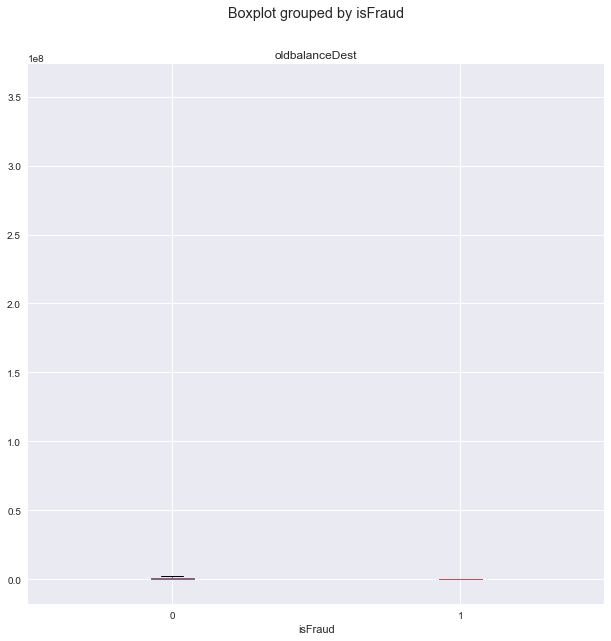

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
l=['oldbalanceDest']
dataset.boxplot(l,'isFraud',ax)
plt.show()

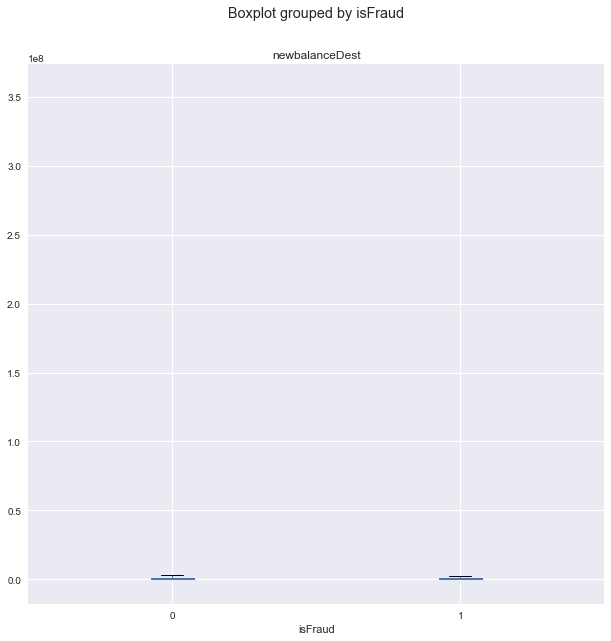

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
l=['newbalanceDest']
dataset.boxplot(l,'isFraud',ax)
plt.show()

# data preprocessing

In [21]:
#check number of NaN value in each column
missing_values_count = dataset.isnull().sum()
missing_values_count[0:10]

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [22]:
#there is no NaN value so just change one and then impute one
dataset.ix[100,'isFlaggedFraud']=np.NaN
#check which row has NaN
dataset[dataset['isFlaggedFraud'].isnull()]
#impute mean value in the nan place

#take important columns split train test
dataset_pred=dataset[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest', 'isFraud','isFlaggedFraud']]
X = dataset_pred.loc[:,dataset_pred.columns != 'isFraud'].values 
y = dataset_pred.iloc[:, 7].values 

#impute mean value 
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0) 
imputer = imputer.fit(X[:,7:8]) 
X[:,7:8] = imputer.transform(X[:,7:8]) 


C:\Users\suman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [23]:
#use encoder
labelencoder_X_1 = LabelEncoder() 
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1]) 
#labelencoder_X_2 = LabelEncoder() 
#X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2]) 
#create dummy variable for type 5 type as there are catagory not working
onehotencoder = OneHotEncoder(categorical_features=[1]) #apply in column type as there are more than 2 catagory
X = onehotencoder.fit_transform(X).toarray() 


# split data in train and test

In [24]:
# splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 
#check traing data spread fraud and nonfraud are equally sprea in train and test
np.count_nonzero(y_test==1)
np.count_nonzero(y_test==0)
np.count_nonzero(y_train==1)
np.count_nonzero(y_train==0)


5083524

# Model building

In [25]:
# build model Logistic regression
classifier = LogisticRegression(class_weight={0:0.1,1:.9},random_state = 0) 
classifier.fit(X_train, y_train) 



#try grid search
#grid = {
#         'C': np.power(5.0, np.arange(-2, 2)),
#          'penalty' : ['l2'] # no support of l1 penalty
#         , 'solver': ['liblinear']#'newton-cg',
#    }
#classifier = LogisticRegression(class_weight={0:0.1,1:.9},random_state = 0)
#gs = GridSearchCV(classifier, param_grid=grid, scoring='roc_auc', cv=5)
#gs1=gs.fit(X_train, y_train)

#print ('gs.best_score_:', gs1.best_score_)

# build model Logistic regression using abobe C parameter
#classifier = LogisticRegression(class_weight={0:0.1,1:.9},C=1, random_state = 0) 
#classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Accuracy check

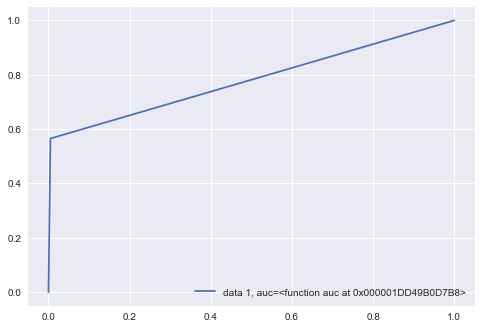

In [26]:
y_pred = classifier.predict(X_test) 
mat=pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
#positive is fraud, negative is not fraud
tp=mat.iloc[1,1]
tn=mat.iloc[0,0]
fp=mat.iloc[0,1]
fn=mat.iloc[1,0]
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fscore=2*precision*recall/(precision+recall)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() 
logloss=log_loss(y_test, y_pred)

#area under curve = .78 for logistic regression class weight .1,.9, penalty L2
#fscore=.21 best  1 and worst 0  for logistic regression class weight .1,.9, penalty L2
#logloss .19

#without upsampled
#Predicted        0     1      
#True                             
#0          1269657(TN) 1226(FP)  
#1              953(FN) 688(TP)  1270345/1272524 = 99% but FP FN are huge we have to reduce type2 error 

#after balancing of data 
#Predicted        0        1     
#True                                
#0          1155862   113783
#1           128950  1143168  
#with classweight {0:0.1,1:.9}
#Predicted        0     1    
#True                             
#0          1264761  6122  
#1              713   928
#try grid search with different parameter




# try SVM

In [ ]:
#try SVM but its very slow so left it without executing code

classifier = SVC(kernel = 'linear', random_state = 0) 
classifier.fit(X_train, y_train) 
# Predicting the Test set results 
y_pred = classifier.predict(X_test) 

mat=pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
#positive is fraud, negative is not fraud
tp=mat.iloc[1,1]
tn=mat.iloc[0,0]
fp=mat.iloc[0,1]
fn=mat.iloc[1,0]
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fscore=2*precision*recall/(precision+recall)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() 
logloss=log_loss(y_test, y_pred)
#area under curve = .78 for logistic regression class weight .1,.9, penalty L2
#fscore=.21 best  1 and worst 0  for logistic regression class weight .1,.9, penalty L2
#logloss .19

#without upsampled
#Predicted        0     1      
#True                             
#0          1269657(TN) 1226(FP)  
#1              953(FN) 688(TP)  1270345/1272524 = 99% but FP FN are huge we have to reduce type2 

# Try XGBoost

In [ ]:
#try XGBoost package is not installed connection error



 
classifier = XGBClassifier() 
classifier.fit(X_train, y_train) 

# Predicting the Test set results 
y_pred = classifier.predict(X_test) 

mat=pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
#positive is fraud, negative is not fraud
tp=mat.iloc[1,1]
tn=mat.iloc[0,0]
fp=mat.iloc[0,1]
fn=mat.iloc[1,0]
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fscore=2*precision*recall/(precision+recall)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() 
logloss=log_loss(y_test, y_pred)
#Predicted        0     1      All
#True                             
#0          1270872    11  1270883
#1              496  1145     1641
#All        1271368  1156  1272524

#fscore .818


#use adaboost
dt = DecisionTreeClassifier() 
clf = AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=1)
#Above I have used decision tree as a base estimator, any ML learner as base estimator  
#100 decision tree are used as week learner
clf.fit(X_train,y_train)

#remove unwanted variables
del X,dataset,dataset_pred

# Predicting the Test set results 
y_pred = clf.predict(X_test) 

mat=pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
#positive is fraud, negative is not fraud
tp=mat.iloc[1,1]
tn=mat.iloc[0,0]
fp=mat.iloc[0,1]
fn=mat.iloc[1,0]
precision=tp/(tp+fp)
recall=tp/(tp+fn)
fscore=2*precision*recall/(precision+recall)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() 
logloss=log_loss(y_test, y_pred)
#Predicted        0     1      All
#True                             
#0          1270714   169  1270883
#1              197  1444     1641
#All        1270911  1613  1272524

#fscore .88

#so this is performing well


